In [98]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from MSquared_methods import *

plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})

In [99]:
# Pixel size
dx, dy = 5.3E-3, 5.3E-3 # mm
# Translation step
dz = 0.4 # mm

In [116]:
raw = True

In [117]:
if raw:
    filedir = "Data/85-0mA_Raw_ZScan_0-2mm"
else:
    filedir = "Data/85-0mA_Filtered_ZScan_0-2mm"

number = lambda filename: int(filename.split("_")[-1].replace(".tif", ""))
filenames = sorted(os.listdir(filedir), key=number)
    
irradiances = []
for i, filename in enumerate(filenames):
    imarray = np.array(Image.open(os.path.join(filedir, filename)))
    if raw: imarray = imarray[:, :, 0]
    irradiances.append(imarray)

In [118]:
Wy2s = np.zeros(len(irradiances))
Wx2s = np.zeros(len(irradiances))

save = False
for i, irradiance in enumerate(irradiances):
    shape = irradiance.shape
    og_y, og_x = dy * np.arange(0, shape[0]), dx * np.arange(0, shape[1])

    if raw:
        kernel_length_y, comparison_length_y, error_y, symmetric_y = 20, 10, 2E-4, False
        if i == 20:
            kernel_length_x, comparison_length_x, error_x, symmetric_x = 15, 5, 1.3E-4, True
        else:
            kernel_length_x, comparison_length_x, error_x, symmetric_x = 15, 5, 1.2E-4, True
    else:
        kernel_length_y, comparison_length_y, error_y, symmetric_y = 10, 3, 2E-4, False
        kernel_length_x, comparison_length_x, error_x, symmetric_x = 10, 3, 2E-4, False
    Wy2, y0, y, marginals_y, og_marginals_y = get_Wy2(irradiance, og_y, dx, dy,
                                                      kernel_length_y, comparison_length_y, error_y, symmetric_y)
    Wx2, x0, x, marginals_x, og_marginals_x = get_Wx2(irradiance, og_x, dx, dy,
                                                      kernel_length_x, comparison_length_x, error_x, symmetric_x)

    Wy2s[i] = Wy2
    Wx2s[i] = Wx2

    if raw: title = f"Raw_Irradiance_Image_{i}"
    else: title = f"Filtered_Irradiance_Image_{i}"
    if save:
        save_1D_irradiance(y0, y, marginals_y, x0, x, marginals_x, title, save=True)
        # plt.plot(og_y, 100*og_marginals_y, color="r")
        # plt.plot(og_x, 100*og_marginals_x, color="b")
        plt.show()

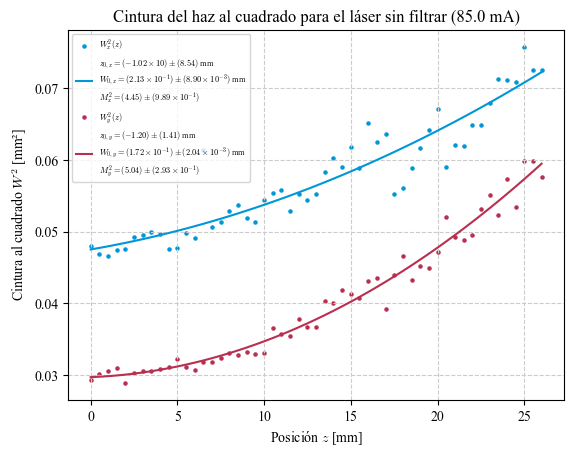

In [119]:
wl = 681.64 * 1E-6 # mm

dz = 0.5 # mm
z = dz * np.arange(0, len(irradiances), 1)
z0y, W0y, M2y, W2_func_y = W2_fit(z, Wy2s, wl)
z0x, W0x, M2x, W2_func_x = W2_fit(z, Wx2s, wl)

fig, ax = plt.subplots()

if raw:
    title = "Cintura del haz al cuadrado para el láser sin filtrar (85.0 mA)"
    filename = "Raw_Waist.png"
else:
    title = "Cintura del haz al cuadrado para el láser filtrado (85.0 mA)"
    filename = "Filtered_Waist.png"
ax.set(title=title,
       ylabel=f"Cintura al cuadrado $W^2$ [mm²]", xlabel="Posición $z$ [mm]")
plot_W2_fit(z, Wx2s, W2_func_x, z0x, W0x, M2x, "x", "#0097d8", fig, ax)
plot_W2_fit(z, Wy2s, W2_func_y, z0y, W0y, M2y, "y", "#b92f4f", fig, ax)

plt.savefig(f"Figures/{filename}", dpi=200)

In [120]:
if raw: csv_filename = "Figures/Raw_BeamParameters.csv"
else: csv_filename = "Figures/Filtered_BeamParameters.csv"
    
data_dict = {
             "$z_0$ [mm]": ["$" + ufloat_to_str(z0x) + "$", "$" + ufloat_to_str(z0y) + "$"],
             "$W_0$ [mm]": ["$" + ufloat_to_str(W0x) + "$", "$" + ufloat_to_str(W0y) + "$"],
             "$M^2$": ["$" + ufloat_to_str(M2x) + "$", "$" + ufloat_to_str(M2y) + "$"],
             "$M^2$ / $W_0$ [mm$^{-1}$]": ["$" + ufloat_to_str(M2x / W0x) + "$", "$" + ufloat_to_str(M2y / + W0y) + "$"]
            }
df = pd.DataFrame(data_dict)
df.to_csv(csv_filename)

In [121]:
def percent_error(A, B):
    return 100 * np.abs(A - B) / np.abs(np.mean((A, B)))

In [122]:
x1 = percent_error(z0x, z0y)
x2 = percent_error(W0x, W0y)
x3 = percent_error(M2x/W0x, M2y/W0y)
print(x1.n, x2.n, x3.n)

157.8509645958836 21.21666639561926 33.40774922793223


In [115]:
M2x_now, M2y_now = M2x, M2y

In [125]:
print(M2x / M2x_now)

4.1+/-0.9


In [126]:
print(M2y / M2y_now)

4.80+/-0.33
